## Gaussian mixture models for going to the pub
In the video lecture we saw that the Wetherspoons on Park St has visiting times on a Sunday that look as if they can be well modelled by a mixture of Gaussians. Let's look into how we model that.
<img src="restaurant.png" alt="drawing" width="500"/>


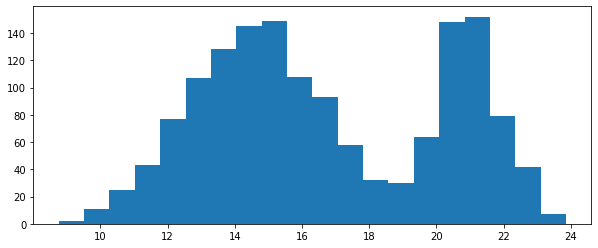

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm
from numpy.random import default_rng

rng=default_rng(100)

x1 = rng.normal(loc=14.5, scale=2, size=1000)
x2 = rng.normal(loc=21, scale=1, size=500)
x=np.hstack([x1, x2])
fig, ax = plt.subplots(figsize=(10, 4))
n, bins, patch = plt.hist(x, bins=20)

bin_length=bins[1]-bins[0]
sf1=bin_length*len(x1)
sf2=bin_length*len(x2)



We first make a guess at the means and the standard deviation. Let's guess that the mean of one cluster is 14 (i.e.  2 pm) and that the mean of the other cluster is 20 (i.e. 8 pm), and that the standard deviation of each is 1. Let's also say that each cluster has weight 0.5.

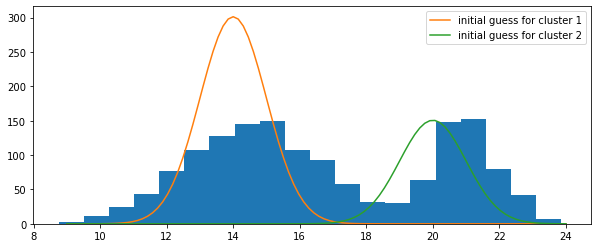

In [2]:
mu1=14
mu2=20
sigma1=sigma2=1
w1=w2=0.5
xs=np.linspace(9, 24, 100)
ax.plot(xs, norm.pdf(xs, loc=mu1, scale=sigma1)*sf1, label='initial guess for cluster 1')
ax.plot(xs, norm.pdf(xs, loc=mu2, scale=sigma2)*sf2, label='initial guess for cluster 2')
ax.legend()
fig

Let's consider the point midday, or 12. We can compute the membership of 12 in each cluster as follows:

The membership of $x$ in cluster $j$ is $$m_j(x)=\frac{f_j(x)w_j}{\sum_{i=1}^k f_i(x)w_i}$$
where $f_i(x)$ is the pdf of the normal distribution with mean = $\mu_i$ and standard deviation = $\sigma_i$

In [3]:
weighted_pdf_1=w1*norm.pdf(12, loc=mu1, scale=sigma1)
weighted_pdf_2=w2*norm.pdf(12, loc=mu2, scale=sigma2)
print(weighted_pdf_1, weighted_pdf_2)

0.02699548325659403 2.5261355417684464e-15


In [4]:
membership_1 = weighted_pdf_1/(weighted_pdf_1+weighted_pdf_2)
membership_2 = weighted_pdf_2/(weighted_pdf_1+weighted_pdf_2)
print(membership_1, membership_2)

0.9999999999999064 9.357622968839298e-14


In [6]:
def memberships(x, means=[mu1, mu2], stds=[sigma1, sigma2], ws=[w1, w2]):
    weighted_pdf_1=ws[0]*norm.pdf(x, loc=means[0], scale=stds[0])
    weighted_pdf_2=ws[1]*norm.pdf(x, loc=means[1], scale=stds[1])
    membership_1 = weighted_pdf_1/(weighted_pdf_1+weighted_pdf_2)
    membership_2 = weighted_pdf_2/(weighted_pdf_1+weighted_pdf_2)
    return(np.vstack([membership_1, membership_2]))

In [7]:
memberships(12)

array([[1.00000000e+00],
       [9.35762297e-14]])

In [8]:
memberships(22)

array([[9.35762297e-14],
       [1.00000000e+00]])

In [9]:
memberships(17)

array([[0.5],
       [0.5]])

In [10]:
ms = memberships(x)

Based on these memberships, we will now calculate the new means. The new means will be a weighted sum of the points in the dataset, where the weighting  is based on the memberships we have just calculated.
$${\mu}_{j}^\prime= \frac{\sum_{x} m_j(x)x }{\sum_{x} m_j(x)  }$$
Compare with k-means: in k-means, memberships are just 1 or 0, and we calculate the new means by taking the average of all the points that have membership 1 in a cluster.

In [11]:
def calc_means(x, ms):
    denoms = np.sum(ms, axis=1)
    numtrs = np.sum(ms*x, axis=1)
    return numtrs/denoms

In [12]:
new_means= calc_means(x, ms)
print(new_means)

[14.12996613 20.40239905]


We now calculate the new standard deviations based on the memberships and the new means.

$${\sigma_j^\prime}^2=\frac{\sum_{x} m_j(x)(x-{\mu}_j^\prime)^2}{\sum_{x} m_j(x)}$$

In [13]:
def calc_stds(x, mus, ms):
    denoms = np.sum(ms, axis=1)
    numtrs = np.sum(ms*((x - mus.reshape(-1,1))**2), axis=1)
    return np.sqrt(numtrs/denoms)

In [14]:
new_stds = calc_stds(x, new_means, ms)
print(new_stds)

[1.67038545 1.56056397]


Finally, we calculate the new weights for each cluster
$$w_j^\prime=\frac{ \sum_{x} m_j(x) }{N}$$
where $N$ is the total number of points (in our case 1500)

In [15]:
def calc_ws(ms):
    return np.sum(ms, axis=1)/ms.shape[1]

In [16]:
calc_ws(ms)

array([0.58547593, 0.41452407])

Let's plot our updated curves:

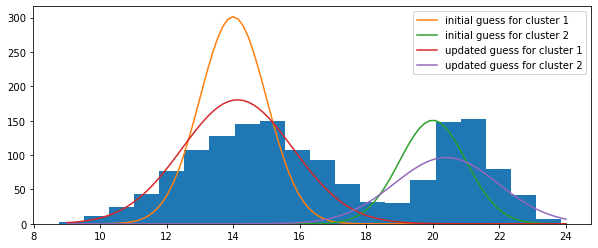

In [17]:
ax.plot(xs, norm.pdf(xs, loc=new_means[0], scale=new_stds[0])*sf1, label='updated guess for cluster 1')
ax.plot(xs, norm.pdf(xs, loc=new_means[1], scale=new_stds[1])*sf2, label='updated guess for cluster 2')
ax.legend()
fig

Now, we want to continue running all these steps until we see no more changes

In [18]:
mus=np.array([mu1, mu2])
sigmas=np.array([sigma1, sigma2])
ws=np.array([w1, w2])
convergence = False
while not convergence:
    ms = memberships(x, mus, sigmas, ws)
    new_mus = calc_means(x, ms)
    new_sigmas = calc_stds(x, new_mus, ms)
    new_ws = calc_ws(ms)
    convergence = np.allclose(mus, new_mus) and np.allclose(sigmas, new_sigmas) and np.allclose(ws, new_ws)
    mus = new_mus
    sigmas = new_sigmas
    ws = new_ws

In [19]:
mus

array([14.57559948, 21.00477774])

In [20]:
sigmas

array([2.00430176, 0.96305524])

In [21]:
ws

array([0.66489636, 0.33510364])

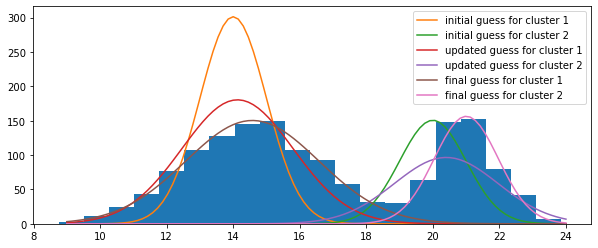

In [22]:
ax.plot(xs, norm.pdf(xs, loc=mus[0], scale=sigmas[0])*sf1, label='final guess for cluster 1')
ax.plot(xs, norm.pdf(xs, loc=mus[1], scale=sigmas[1])*sf2, label='final guess for cluster 2')
ax.legend()
fig

In [23]:
memberships(17, mus, sigmas, ws)

array([[9.99616915e-01],
       [3.83085160e-04]])